Who is better 2-Pointer Player: Wes Matthews in 1982 or Randy Brown in 1994?

Randy Brown in 1994 has a slightly higher 2P%(0.445344) than Wes Matthews in 1982(0.444828).But can we say with confidence that his skill is actually higher, or is it possible he just got lucky a bit more often?

To answer this question, we're going to look at an empirical Bayesian approach to comparing two players. We'll define the problem in terms of the difference between each player's posterior distribution, and look at four mathematical and computational strategies
we can use to resolve this question.

This is a topic of the data science field. Understanding the difference between two proportions is important in **A/B testing**. 

## Setup dataset

In [1]:
import os
import math
import pandas as pd
from scipy.stats import beta, chi2_contingency
import scipy.special as sc
import numpy as np
import matplotlib.pyplot as plt
project_dir = '/mnt/data-ubuntu/Projects/statistics_python3'
df = pd.read_csv(project_dir + '/data/nba-players-stats/seasons_stats_pg.csv')

In [2]:
data = df.loc[:,'2P%'][(df.loc[:,'2P%']<1) & (df.loc[:,'2P%']>0)]
beta_fit = beta.fit(data = data, floc=0, fscale=1)
a = round(beta_fit[0], 2)
b = round(beta_fit[1], 2)
print(f'a: {a},b: {b}')
df.head()

a: 23.05,b: 29.35


,Year,Player,Pos,2P,2PA,2P%,2P%_estimate,a_i,b_i,low,high,PEP,q_value
0,1988.0,John Stockton*,PG,430.0,724.0,0.593923,0.583527,453.05,323.35,0.548679,0.617967,4.987049e-16,4.987049e-16
1,1996.0,Anfernee Hardaway,PG,534.0,932.0,0.572961,0.565878,557.05,427.35,0.534811,0.596690,1.130444e-15,8.145743e-16
2,1985.0,Magic Johnson*,PG,497.0,862.0,0.576566,0.568734,520.05,394.35,0.536516,0.600666,2.803071e-15,1.477407e-15
3,2006.0,Tony Parker,PG,612.0,1100.0,0.556364,0.551067,635.05,517.35,0.522284,0.579683,1.902598e-14,5.864550e-15
4,1984.0,Magic Johnson*,PG,435.0,751.0,0.579228,0.570139,458.05,345.35,0.535772,0.604176,6.652018e-14,1.799568e-14


## Comparing posterior distributions

In [3]:
#Wes Matthews in 1982 or Randy Brown in 1994
df.iloc[[1848,1849]]

,Year,Player,Pos,2P,2PA,2P%,2P%_estimate,a_i,b_i,low,high,PEP,q_value
1848,1994.0,Randy Brown,PG,110.0,247.0,0.445344,0.444389,133.05,166.35,0.388590,0.500891,0.439405,0.133776
1849,1982.0,Wes Matthews,PG,129.0,290.0,0.444828,0.444071,152.05,190.35,0.391863,0.496899,0.439666,0.133941


We see that Randy Brown has a a slightly higher empirical bayes estimate(0.444389). But is he true probability of getting a goal higher?

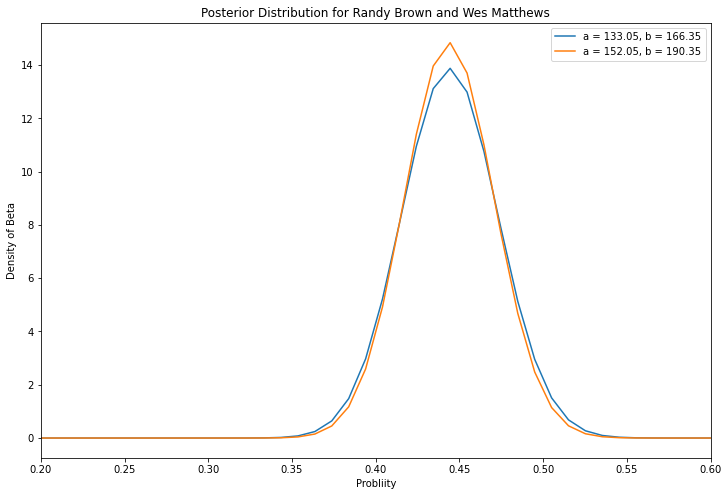

In [4]:
# Plot the players' posterior distributions
fig,ax = plt.subplots(figsize=(12, 8))
x = np.linspace(0,1,100)
for i, p in df.iloc[[1848,1849]].iterrows():
    a_i = p.loc['a_i']
    b_i = p.loc['b_i']

    df_temp = pd.DataFrame({'Probability': x, f'a = {a_i}, b = {b_i}': beta.pdf(x, a_i, b_i)})
    df_temp.set_index('Probability') \
        .plot(ax = ax,
              legend = True,
              xlim = (0.2, 0.6))

    plt.ylabel('Density of Beta')
    plt.xlabel('Probliity')
    plt.title('Posterior Distribution for Randy Brown and Wes Matthews')
legend = ax.legend(loc='upper right')
plt.show()


Quantify the problem.

We'd need to know the probability one beta distribution is greater than another.
This question is not trivial to answer, and I'm going to illustrate four routes that
are common lines of attack in a Bayesian problem:
* Simulation of posterior draws
* Numerical integration
* Closed-form solution
* Closed-form approximation

### Simulation of posterior draws

We could simply try simulation. We could use each player's a and b parameters, draw a million items from each of them, and compare the results.

In [5]:
# Let's do 1 million tests
randy_brown = beta \
    .rvs(df.loc[1848,'a_i'],
         df.loc[1848,'b_i'],
         size=int(1e7),
         random_state=0)
wes_matthews = beta \
    .rvs(df.loc[1849,'a_i'],
         df.loc[1849,'b_i'],
         size=int(1e7),
         random_state=1)
r_w = np.mean(randy_brown > wes_matthews)
print(f'The probability that Randy is better than Wes is {r_w}')

The probability that Randy is better than Wes is 0.5029337


### Numerical integration

These two posteriors each have their own (independent) distribution, and together
they form a joint distribution- that is, a density over particular pairs of x and y.

In [6]:
# Draw the joint distribution
# TBD

### Closed-form solution

[This post](https://www.evanmiller.org/bayesian-ab-testing.html#binary_ab_derivation) lays out a closed-form solution Miller derived for the probability a draw from one beta distribution is greater than a draw from another.

In [7]:
def compare_two(A_a, A_b, B_a, B_b):
    """
    Calcualte the probability of Beta(B_a, B_b) > Beta(A_a, A_b).
    """
    total = 0
    for i in range(int(B_a)):
        total += np.exp(sc.betaln(A_a+i, B_b+A_b) \
                     - np.log(B_b+i) \
                     - sc.betaln(1+i, B_b) \
                     - sc.betaln(A_a, A_b))
    return total

In [8]:
r_w = compare_two(df.loc[1848,'a_i'],
                  df.loc[1848,'b_i'],
                  df.loc[1849,'a_i'],
                  df.loc[1849,'b_i'])
print(f'The probability that Randy is better than Wes is {r_w}')

The probability that Randy is better than Wes is 0.4961068628930334


### Closed-form approximation


As this report points out, there's a much faster approximation we can use. Notice
that when a and b are both fairly large, the beta starts looking a lot like a **normal
distribution**, so much so that it can be closely approximated.

But it's not recommended in our case, since the a and b are small.

## Confidence and credible intervals

In classical (frequentist) statistics, we may have seen this kind of "compare two
proportions" problem before, perhaps laid out as a "contingency table".

In [9]:
df_chi = df.loc[[1848, 1849], ['Player', '2P', '2PA']]
df_chi['misses'] = df_chi.loc[:, '2PA'] - df_chi.loc[:, '2P']
df_chi

,Player,2P,2PA,misses
1848,Randy Brown,110.0,247.0,137.0
1849,Wes Matthews,129.0,290.0,161.0


One of the most common ways to approach these contingency table problems is with Pearson's chi-squared test

In [10]:
chi2_stat, p_val, dof, ex = chi2_contingency(df_chi.loc[:,['2P', 'misses']].values)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")
print("===Contingency Table===")
print(ex)

===Chi2 Stat===
0.005641143665352493


===Degrees of Freedom===
1


===P-Value===
0.9401291428909169


===Contingency Table===
[[109.9310987 137.0689013]
 [129.0689013 160.9310987]]


We see a non-significant p-value of 0.94, indicating the test couldn't find a
difference.